In [72]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import json

from pathlib import Path
from tqdm import tqdm

In [2]:
# TODO
# Multiple Matching, Static
# Multiple Matching, Video
# Evalution
# Deep Scale Invariant Methods
# Module, Pydantic

In [3]:
# Keypoints:
# - Distinctive locations in the image (corners, edges, blobs) detected using the Scale-Invariant Feature Transform (SIFT). 
# - They remain stable across scale, rotation, and minor affine transformations.

# Descriptors:
# - 128-dimensional vectors that encode local gradient information around the keypoints.

# FLANN
# - Fast Library for Approximate Nearest Neighbors (FLANN) used to match feature descriptos between templae and target.
# - KD-Tree index structure for high-dimensional nearest neigbhor search.

# Lowe's Ratio Test
# - Filter ambiguous matches, where an acceptable match has a nearest neighbour significantly close, <THRESHOLD>X second best match.
# - Ensures only distinctive, high-quality matches remain.

# RANSAC
# - Homography (projection between 2 planes) estimation to identify the transform between corresponding points to align the template onto the target.
# - Find Hoographic Matrix H

# Grayscale yields computational efficiency, reducing computational complexity by 1/3; Matrix moves from 3-channel features -> 1 channel.


In [4]:
TEMPLATE_SIZE = (274, 274)

def scale_img(image, target_size):
    """ Scale with fixed aspect ratio. """
    target_w, target_h = target_size
    h, w = image.shape[:2]

    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)

    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    return resized_image

def load_template(template_path, size):
    ""
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    template = scale_img(template, size)
    return template

def load_img(img_path):
    color_img = cv2.imread(img_path)
    grayscale_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)

    return color_img, grayscale_img

def sift_match(template, grayscale_img, color_img,):
    """ 
    Matching Algorithm: SIFT
    - Extract SIFT Keypoints, Descriptors: Template
    - Compute SIFT Keypoints, Descriptors: Target
    - FLANN Matching
    - Retain Good-Matches: Ratio-Test
    - Compute Bounding Box RANSAC Homography
    - Draw Bounding Boxes
    """
    sift = cv2.SIFT_create()

    keypoints1, descriptors1 = sift.detectAndCompute(template, None)
    keypoints2, descriptors2 = sift.detectAndCompute(grayscale_img, None)

    # FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Lowe’s Ratio Test
    good_matches = []
    pts1, pts2 = [], []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
            pts1.append(keypoints1[m.queryIdx].pt)
            pts2.append(keypoints2[m.trainIdx].pt)

    pts1 = np.float32(pts1).reshape(-1, 1, 2)
    pts2 = np.float32(pts2).reshape(-1, 1, 2)

    # RANSAC
    if len(pts1) >= 4:  # Homographic Minimum
        H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
    else:
        H, matchesMask = None, None

    filtered_pts = pts2[matchesMask == 1] if H is not None else pts2

    if len(good_matches) > 4:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        if H is not None:
            h, w = template.shape
            corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)

            transformed_corners = cv2.perspectiveTransform(corners, H)

            target_with_bbox = color_img.copy()
            cv2.polylines(target_with_bbox, [np.int32(transformed_corners)], True, (0, 255, 0), 3)

            plt.figure(figsize=(12, 6))
            plt.imshow(cv2.cvtColor(target_with_bbox, cv2.COLOR_BGR2RGB))
            plt.title(f"SIFT - {len(good_matches)}")
            plt.axis("off")
            plt.show()
        else:
            print("NO BOUNDING")
    else:
        print("NO MATCH")

    # Feature Correspondance Visualisation
    # matched_img = cv2.drawMatches(template, keypoints1, color_img, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [5]:
data_dir = Path("data/imgs/raw")
data = [str(file) for file in data_dir.rglob('*.jpg')]

data

['data/imgs/raw/img_158.jpg',
 'data/imgs/raw/img_023.jpg',
 'data/imgs/raw/img_026.jpg',
 'data/imgs/raw/img_202.jpg',
 'data/imgs/raw/img_020.jpg',
 'data/imgs/raw/img_009.jpg',
 'data/imgs/raw/img_194.jpg',
 'data/imgs/raw/img_132.jpg',
 'data/imgs/raw/img_155.jpg',
 'data/imgs/raw/img_195.jpg',
 'data/imgs/raw/img_111.jpg',
 'data/imgs/raw/img_134.jpg',
 'data/imgs/raw/img_197.jpg',
 'data/imgs/raw/img_128.jpg',
 'data/imgs/raw/img_039.jpg',
 'data/imgs/raw/img_165.jpg',
 'data/imgs/raw/img_157.jpg',
 'data/imgs/raw/img_173.jpg',
 'data/imgs/raw/img_003.jpg',
 'data/imgs/raw/img_179.jpg',
 'data/imgs/raw/img_053.jpg',
 'data/imgs/raw/img_108.jpg',
 'data/imgs/raw/img_085.jpg',
 'data/imgs/raw/img_149.jpg',
 'data/imgs/raw/img_034.jpg',
 'data/imgs/raw/img_066.jpg',
 'data/imgs/raw/img_027.jpg',
 'data/imgs/raw/img_189.jpg',
 'data/imgs/raw/img_192.jpg',
 'data/imgs/raw/img_056.jpg',
 'data/imgs/raw/img_048.jpg',
 'data/imgs/raw/img_097.jpg',
 'data/imgs/raw/img_088.jpg',
 'data/img

In [6]:
template_path = "data/brand_assets/raw/sainsburys_template.jpg" 
tgt_path = "data/imgs/raw/img_001.jpg"

template = load_template(template_path=template_path, size=TEMPLATE_SIZE)
tgt, tgt_gray = load_img(img_path=tgt_path)

274 97
1418 1417


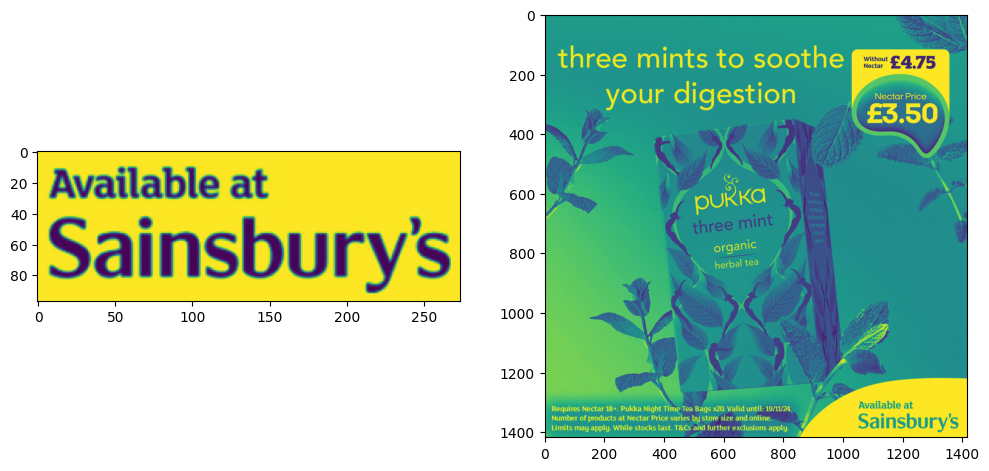

In [7]:
# ASSERT IMAGES
w, h = template.shape[::-1]
print(w, h)

w_, h_ = tgt_gray.shape[::-1]
print(w_, h_)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(template)
axes[1].imshow(tgt_gray)

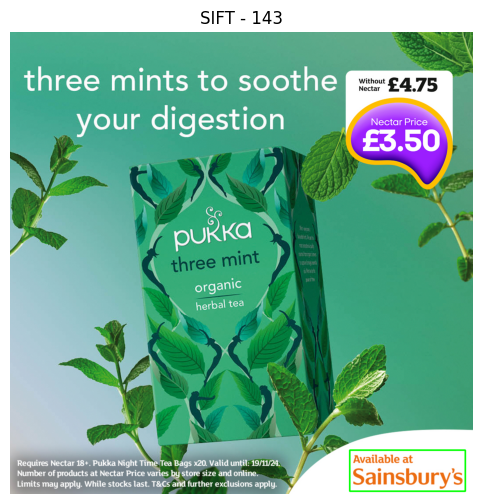

In [8]:
### SIFT MATCH ###
sift_match(template, tgt_gray, tgt)

In [9]:
### Evaluation Framework ###
# - Intersection over Union; IoU > 0.75 == High Confidence
# - Precision, Recall, F1
# - mAP (Mean Average Precision)

In [50]:
### LOAD ANNOATIONS ###
def load_coco(annot_path):
    with open(annot_path, "r") as f:
        data = json.load(f)
    
    return data["images"], data["annotations"]

In [73]:
def sift_match(template, grayscale_img):
    """ 
    Matching Algorithm: SIFT
    Returns: Detected bounding box [x_min, y_min, width, height] (COCO format)
    """
    sift = cv2.SIFT_create()

    # Extract keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(template, None)
    keypoints2, descriptors2 = sift.detectAndCompute(grayscale_img, None)

    if descriptors1 is None or descriptors2 is None:
        print("⚠️ No descriptors found!")
        return []  # No descriptors means no matches

    # FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Lowe’s Ratio Test
    good_matches = []
    pts1, pts2 = [], []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
            pts1.append(keypoints1[m.queryIdx].pt)
            pts2.append(keypoints2[m.trainIdx].pt)

    if len(good_matches) < 4:
        print("❌ Not enough good matches found for homography")
        return []  # Not enough matches for homography

    pts1 = np.float32(pts1).reshape(-1, 1, 2)
    pts2 = np.float32(pts2).reshape(-1, 1, 2)

    # RANSAC Homography
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    if H is None:
        print("❌ Homography computation failed!")
        return []  # No valid homography found

    # Debugging Homography Matrix
    print(f"✅ Homography computed: \n{H}")

    # Compute Bounding Box
    h, w = template.shape[:2]
    corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)

    try:
        transformed_corners = cv2.perspectiveTransform(corners, H)
    except cv2.error as e:
        print(f"❌ OpenCV Perspective Transform Failed: {e}")
        return []  # Return empty if the transform fails

    transformed_corners = transformed_corners.reshape(-1, 2)  # Convert to (x, y) format

    x_min = np.min(transformed_corners[:, 0])
    y_min = np.min(transformed_corners[:, 1])
    x_max = np.max(transformed_corners[:, 0])
    y_max = np.max(transformed_corners[:, 1])

    bbox = [int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)]  # COCO format

    return [bbox]

In [74]:
import io
import sys

def compute_iou(boxA, boxB):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    intersection = max(0, xB - xA) * max(0, yB - yA)
    union = (boxA[2] * boxA[3]) + (boxB[2] * boxB[3]) - intersection

    return intersection / union if union > 0 else 0

def evaluate(img_sample, test, detector_fn, template, iou_threshold=0.5):
    """
    Evaluates the detector against ground truth annotations.
    
    Args:
        img_sample (list): List of image metadata dictionaries.
        test (list): List of COCO-style annotations.
        detector_fn (function): Detector function that returns bounding boxes.
        template (numpy array): Template image for matching.
        iou_threshold (float): Minimum IoU to count as a true positive.

    Returns:
        dict: Precision, Recall, F1 Score, and Mean IoU.
    """
    tp, fp, fn = 0, 0, 0
    iou_scores = []

    log_buffer = io.StringIO()
    original_stdout = sys.stdout

    for img_data in tqdm(img_sample, desc=">> Evaluating ...", unit="image"):
        sys.stdout = log_buffer
        
        img_id = img_data["id"]
        img_path = os.path.join("data/annotations/", img_data["file_name"])
        img = cv2.imread(img_path)

        gt_bboxes = [ann["bbox"] for ann in test if ann["image_id"] == img_id]
        detected_bboxes = detector_fn(img, template)

        matched = set()
        for det_box in detected_bboxes:
            best_iou = 0
            best_gt = None
            for gt_box in gt_bboxes:
                iou = compute_iou(det_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt = tuple(gt_box)

            if best_iou >= iou_threshold:
                tp += 1
                iou_scores.append(best_iou)
                matched.add(best_gt)
            else:
                fp += 1

        fn += len(gt_bboxes) - len(matched)

        sys.stdout = sys.__stdout__
        
    print(log_buffer.getvalue())

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    mean_iou = np.mean(iou_scores) if iou_scores else 0

    print(f">> Evaluation Results:")
    print(f">> Precision: {precision:.3f}")
    print(f">> Recall: {recall:.3f}")
    print(f">> F1 Score: {f1_score:.3f}")
    print(f">> Mean IoU: {mean_iou:.3f}")

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "mean_iou": mean_iou
    }

In [76]:
template_path = "data/brand_assets/raw/nectar_template.jpg"
template = load_template(template_path, size=TEMPLATE_SIZE)

annot_path = "data/annotations/result.json"
imgs, test = load_coco(annot_path)

results = evaluate(imgs, test, detector, template)









































































































































































































>> Evaluating ...: 100%|██████████| 203/203 [00:53<00:00,  3.76image/s]


🔍 Keypoints in Template: 60 | Keypoints in Image: 4583
✅ Good Matches Found: 38
✅ Homography computed successfully!
📌 SIFT Match Detected: [20, 23, 159, 132]
📸 Detector Output: [[20, 23, 159, 132]]
  IoU Debug -> GT: [20, 23, 159, 132], DET: [27.09030100334448, 18.060200668896304, 151.70568561872912, 144.48160535117057], IoU: 0.88
🔍 Keypoints in Template: 60 | Keypoints in Image: 5398
✅ Good Matches Found: 16
✅ Homography computed successfully!
📌 SIFT Match Detected: [764, 167, 125, 104]
📸 Detector Output: [[764, 167, 125, 104]]
🔍 Keypoints in Template: 60 | Keypoints in Image: 3823
✅ Good Matches Found: 32
✅ Homography computed successfully!
📌 SIFT Match Detected: [697, 41, 143, 116]
📸 Detector Output: [[697, 41, 143, 116]]
  IoU Debug -> GT: [697, 41, 143, 116], DET: [704.7529411764706, 40.65882352941176, 137.78823529411747, 121.9764705882353], IoU: 0.89
🔍 Keypoints in Template: 60 | Keypoints in Image: 4603
✅ Good Matches Found: 30
✅ Homography computed successfully!
📌 SIFT Match De

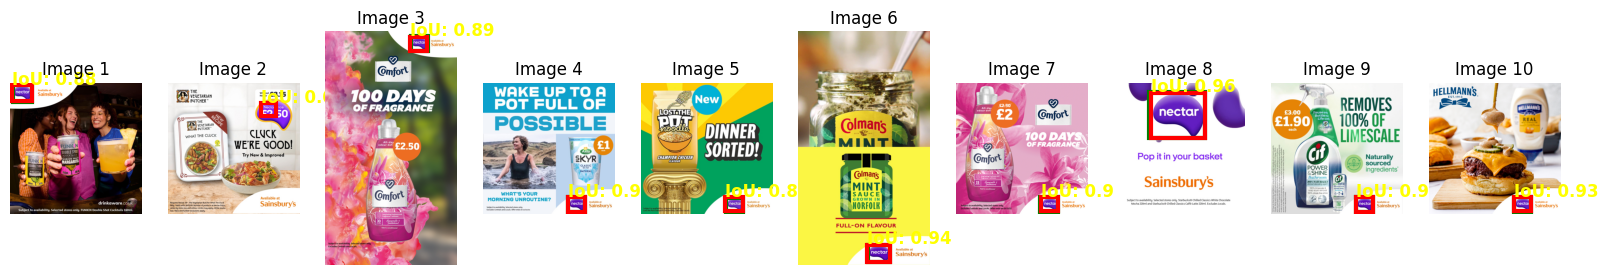

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Select a random sample of 5 images
sample_images = random.sample(imgs, 10)

def visualize_detections(sample_images, test, detector_fn, template):
    fig, axes = plt.subplots(1, 10, figsize=(20, 5))

    for idx, img_data in enumerate(sample_images):
        img_id = img_data["id"]
        img_path = os.path.join("data/annotations/", img_data["file_name"])
        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ ERROR: Could not load {img_path}")
            continue

        gt_bboxes = [ann["bbox"] for ann in test if ann["image_id"] == img_id]
        detected_bboxes = detector_fn(img, template)

        # Convert to RGB for plotting
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Plot ground truth and detections
        axes[idx].imshow(img_rgb)
        axes[idx].axis("off")
        axes[idx].set_title(f"Image {idx + 1}")

        # Draw ground truth (Green)
        for (x, y, w, h) in gt_bboxes:
            rect = plt.Rectangle((x, y), w, h, linewidth=3, edgecolor="green", facecolor="none")
            axes[idx].add_patch(rect)

        # Draw detected boxes (Red)
        for (x, y, w, h) in detected_bboxes:
            rect = plt.Rectangle((x, y), w, h, linewidth=3, edgecolor="red", facecolor="none")
            axes[idx].add_patch(rect)

            # Compute IoU
            best_iou = 0
            for gt_box in gt_bboxes:
                iou = compute_iou([x, y, w, h], gt_box)
                best_iou = max(best_iou, iou)

            axes[idx].text(x, y - 10, f"IoU: {best_iou:.2f}", color="yellow", fontsize=12, fontweight="bold")

    plt.show()

# Run visualization
visualize_detections(sample_images, test, detector, template)

In [78]:
# ### MULTI-MATCH ### img_002
# # multi_img = "data/imgs/raw/img_002.jpg"
# img = random.choice(data)

# #img = "data/imgs/raw/img_130.jpg"
# tgt, tgt_gray = load_img(img_path=img)

# template_paths = [
#     "data/brand_assets/raw/nectar_template.jpg", 
#     "data/brand_assets/raw/sainsburys_template.jpg",
#     "data/brand_assets/raw/nectar_price_template.jpg"
# ]

# templates = [load_template(_, TEMPLATE_SIZE) for _ in template_paths]

# plt.figure(figsize=(10, 8))
# plt.imshow(cv2.cvtColor(tgt, cv2.COLOR_BGR2RGB))

In [215]:
sift = cv2.SIFT_create()

features = []
for template in templates:
    kp, desc = sift.detectAndCompute(template, None)
    
    features.append((template, kp, desc))

In [216]:
kp_tgt, desc_tgt = sift.detectAndCompute(tgt_gray, None)

FLANN_IDX_TREE = 1
idx_params = dict(algorithm=FLANN_IDX_TREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(idx_params, search_params)

In [217]:
# TODO: Walkthrough
THRESHOLD = 0.75
detected_obj = []

for template, kp, desc in features:
    matches = flann.knnMatch(desc, desc_tgt, k=2)

    good_matches = [m for m, n in matches if m.distance < THRESHOLD * n.distance]

    if len(good_matches) > 4:
        print("MATCHES")
        src_pts = np.float32([kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_tgt[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # HOGRAPHY
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        if H is not None:
            h, w = template.shape
            corners = np.float32([[0,0], [w,0], [w,h], [0,h]]).reshape(-1, 1, 2)
            transformed_corners = cv2.perspectiveTransform(corners, H)
            detected_obj.append(np.int32(transformed_corners)) 

MATCHES
MATCHES
MATCHES


In [218]:
detected_obj

[array([[[ 699,  943]],
 
        [[ 840,  944]],
 
        [[ 840, 1059]],
 
        [[ 701, 1060]]], dtype=int32),
 array([[[ 863,  966]],
 
        [[1058,  966]],
 
        [[1058, 1035]],
 
        [[ 863, 1035]]], dtype=int32),
 array([[[ 770,  995]],
 
        [[1445,  976]],
 
        [[ 787,  995]],
 
        [[ 607, 1000]]], dtype=int32)]

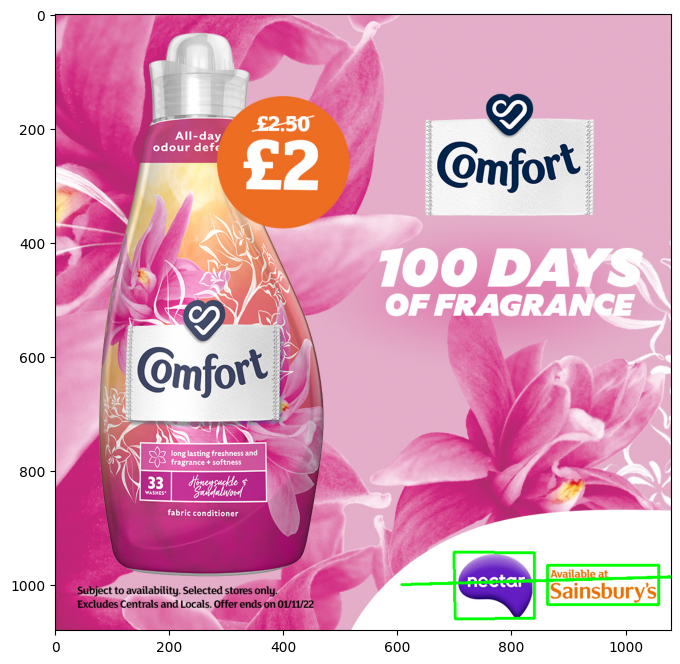

In [242]:
for box in detected_obj:
    cv2.polylines(tgt, [box], True, (0, 255, 0), 3)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(tgt, cv2.COLOR_BGR2RGB))